# A continuous data transformer

We investigate what kind of structural changes are needed so that a "vanilla Transformer" (Attention in All You Need) can be adopted for sequential modeling of continuous data.

Our test signals are sinusoidals of various frequencies that the Transformer should learn to continue.

## Required libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import math

import platform

print(platform.python_version())

3.12.2


## Create data

In [12]:
def gen_sinusoidal(seq_len_, disc_freq_):

    #seq_len = 100
    #disc_freq = 2/seq_len
    t = np.arange(seq_len_)
    y = np.sin(2*np.pi*disc_freq_*t)
    return t,y

Let's define our signals (run repeatedly to see all possibilities)

Sequence length is 71 and frequency 0.0461 (meaning 3.2727 waves per seg) 


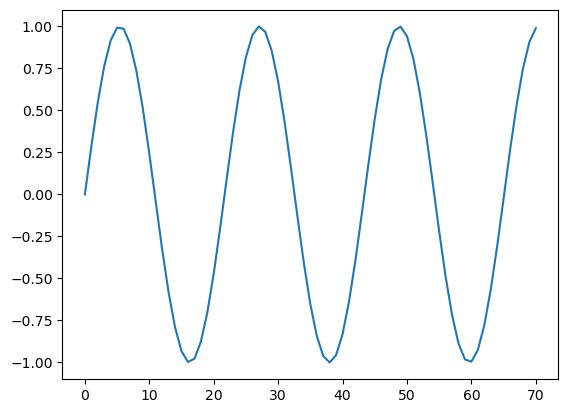

In [157]:
sin_len = 71
max_f = 4/sin_len # To make sure no sampling effects occur too much
sin_f = np.random.uniform(0,max_f)
t,y = gen_sinusoidal(sin_len, sin_f)

print(f'Sequence length is {sin_len} and frequency {sin_f:.4f} (meaning {sin_f*sin_len:.4f} waves per seg) ')
plt.plot(t,y)
plt.show()


Generate training and test data of N sequence samples (for simplicity all of the same lenght)

In [158]:
N_tr = 410
N_te = 310
x_in_len = np.floor(sin_len/2).astype(int)
y_out_len = np.ceil(sin_len/2).astype(int)

X_tr = np.empty((N_tr,x_in_len))
Y_tr = np.empty((N_tr,y_out_len))
X_te = np.empty((N_te,x_in_len))
Y_te = np.empty((N_te,y_out_len))

for ind in range(N_tr):
    sin_f = np.random.uniform(0,max_f)
    t,y = gen_sinusoidal(sin_len, sin_f)

    X_tr[ind,:] = y[0:x_in_len]
    Y_tr[ind,:] = y[x_in_len:]

for ind in range(N_te):
    sin_f = np.random.uniform(0,max_f)
    t,y = gen_sinusoidal(sin_len, sin_f)

    X_te[ind,:] = y[0:x_in_len]
    Y_te[ind,:] = y[x_in_len:]

X_tr = torch.from_numpy(X_tr)
Y_tr = torch.from_numpy(Y_tr)

X_te = torch.from_numpy(X_te)
Y_te = torch.from_numpy(Y_te)

print(f'{N_tr} training and {N_te} test sequences generated')

410 training and 310 test sequences generated


## Continuous time transformer

The baseline model is the discrete symbol transformer from:

 * https://github.com/kamarain/transformer_intro

and its documentation

 * https://arxiv.org/abs/2502.1959

### Necessary libraries

Positional encoding from the original *Seq2SeqTransformer*

In [7]:
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

The original *Seq2SeqTransformer* code

In [ ]:
class Seq2SeqTransformer(nn.Module):
    # Constructor
    def __init__(
        self,
        num_tokens,
        d_model,
        nhead,
        num_encoder_layers,
        num_decoder_layers,
        dim_feedforward,
        dropout_p,
        layer_norm_eps,
        padding_idx = None
    ):
        super().__init__()

        self.d_model = d_model
        self.padding_idx = padding_idx

        if padding_idx != None:
            # Token embedding layer - this takes care of converting integer to vectors
            self.embedding = nn.Embedding(num_tokens+1, d_model, padding_idx = self.padding_idx)
        else:
            # Token embedding layer - this takes care of converting integer to vectors
            self.embedding = nn.Embedding(num_tokens, d_model)
        
        # Token "unembedding" to one-hot token vector
        self.unembedding = nn.Linear(d_model, num_tokens)

        # Positional encoding
        self.positional_encoder = PositionalEncoding(d_model=d_model, dropout=dropout_p)

        # nn.Transformer that does the magic
        self.transformer = nn.Transformer(
            d_model = d_model,
            nhead = nhead,
            num_encoder_layers = num_encoder_layers,
            num_decoder_layers = num_decoder_layers,
            dim_feedforward = dim_feedforward,
            dropout = dropout_p,
            layer_norm_eps = layer_norm_eps,
            norm_first = True
        )

    def forward(
        self,
        src,
        tgt,
        tgt_mask = None,
        src_key_padding_mask = None,
        tgt_key_padding_mask = None
    ):
        # Note: src & tgt default size is (seq_length, batch_num, feat_dim)

        # Token embedding
        src = self.embedding(src) * math.sqrt(self.d_model)
        tgt = self.embedding(tgt) * math.sqrt(self.d_model)

        # Positional encoding - this is sensitive that data _must_ be seq len x batch num x feat dim
        # Inference often misses the batch num
        if src.dim() == 2: # seq len x feat dim
            src = torch.unsqueeze(src,1) 
        src = self.positional_encoder(src)
        if tgt.dim() == 2: # seq len x feat dim
            tgt = torch.unsqueeze(tgt,1) 
        tgt = self.positional_encoder(tgt)

        # Transformer output
        out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask = src_key_padding_mask,
                               tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=src_key_padding_mask)
        out = self.unembedding(out)
        
        return out

Let's define a continuous version where the input embedding is replaced by a linear layer *ContSeq2SeqTransformer*

In [ ]:
class ContSeq2SeqTransformer(nn.Module):
    # Constructor
    def __init__(
        self,
        d_input,
        d_model,
        nhead,
        num_encoder_layers,
        num_decoder_layers,
        dim_feedforward,
        dropout_p,
        layer_norm_eps,
        padding_idx = None
    ):
        super().__init__()

        self.d_model = d_model
        self.padding_idx = padding_idx

        # EDITED
        # nn.Embedding must be replaced with a linear layer - separate for src and tgt as
        # they are not anymore "one-hot-encoded" tokens
        #if padding_idx != None:
        #    # Token embedding layer - this takes care of converting integer to vectors
        #    self.embedding = nn.Embedding(num_tokens+1, d_model, padding_idx = self.padding_idx)
        #else:
        #    # Token embedding layer - this takes care of converting integer to vectors
        #    self.embedding = nn.Embedding(num_tokens, d_model)
        #
        self.tgt_embedding = nn.Linear(d_input, d_model)
        self.src_embedding = nn.Linear(d_input, d_model)

        # EDITED
        ## Token "unembedding" to one-hot token vector 
        #self.unembedding = nn.Linear(d_model, num_tokens)
        self.unembedding = nn.Linear(d_model, d_input)

        # Positional encoding
        self.positional_encoder = PositionalEncoding(d_model=d_model, dropout=dropout_p)

        # nn.Transformer that does the magic
        self.transformer = nn.Transformer(
            d_model = d_model,
            nhead = nhead,
            num_encoder_layers = num_encoder_layers,
            num_decoder_layers = num_decoder_layers,
            dim_feedforward = dim_feedforward,
            dropout = dropout_p,
            layer_norm_eps = layer_norm_eps,
            norm_first = True
        )

    def forward(
        self,
        src,
        tgt,
        tgt_mask = None,
        src_key_padding_mask = None,
        tgt_key_padding_mask = None
    ):
        # Note: src & tgt default size is (seq_length, batch_num, feat_dim)

        # Token embedding EDITED
        #src = self.embedding(src) * math.sqrt(self.d_model)
        #tgt = self.embedding(tgt) * math.sqrt(self.d_model)

        src = self.src_embedding(src) * math.sqrt(self.d_model)
        tgt = self.tgt_embedding(tgt) * math.sqrt(self.d_model)

        
        # Positional encoding - this is sensitive that data _must_ be seq len x batch num x feat dim
        # Inference often misses the batch num
        if src.dim() == 2: # seq len x feat dim
            src = torch.unsqueeze(src,1) 
        src = self.positional_encoder(src)
        if tgt.dim() == 2: # seq len x feat dim
            tgt = torch.unsqueeze(tgt,1) 
        tgt = self.positional_encoder(tgt)

        # Transformer output
        out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask = src_key_padding_mask,
                               tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=src_key_padding_mask)
        out = self.unembedding(out)
        
        return out

In [177]:
class ContSeq2SeqTransformerV2(nn.Module):
    # Constructor
    def __init__(
        self,
        d_input,
        d_model,
        nhead,
        num_encoder_layers,
        num_decoder_layers,
        dim_feedforward,
        dropout_p,
        layer_norm_eps,
        padding_idx = None
    ):
        super().__init__()

        self.d_model = d_model
        self.padding_idx = padding_idx

        # EDITED
        # nn.Embedding must be replaced with a linear layer - separate for src and tgt as
        # they are not anymore "one-hot-encoded" tokens
        #if padding_idx != None:
        #    # Token embedding layer - this takes care of converting integer to vectors
        #    self.embedding = nn.Embedding(num_tokens+1, d_model, padding_idx = self.padding_idx)
        #else:
        #    # Token embedding layer - this takes care of converting integer to vectors
        #    self.embedding = nn.Embedding(num_tokens, d_model)
        #
        self.tgt_embedding = nn.Linear(d_input, d_model)
        self.src_embedding = nn.Linear(d_input, d_model)

        # EDITED AGAIN
        ## Token "unembedding" to one-hot token vector 
        #self.unembedding = nn.Linear(d_model, num_tokens)
        #self.unembedding = nn.Linear(d_model, d_input)
        self.unembedding1 = nn.Linear(d_model, 100)
        self.unembedding2 = nn.Linear(100, d_input)

        # Positional encoding
        self.positional_encoder = PositionalEncoding(d_model=d_model, dropout=dropout_p)

        # nn.Transformer that does the magic
        self.transformer = nn.Transformer(
            d_model = d_model,
            nhead = nhead,
            num_encoder_layers = num_encoder_layers,
            num_decoder_layers = num_decoder_layers,
            dim_feedforward = dim_feedforward,
            dropout = dropout_p,
            layer_norm_eps = layer_norm_eps,
            norm_first = True
        )

    def forward(
        self,
        src,
        tgt,
        tgt_mask = None,
        src_key_padding_mask = None,
        tgt_key_padding_mask = None
    ):
        # Note: src & tgt default size is (seq_length, batch_num, feat_dim)

        # Token embedding EDITED
        #src = self.embedding(src) * math.sqrt(self.d_model)
        #tgt = self.embedding(tgt) * math.sqrt(self.d_model)

        src = self.src_embedding(src) * math.sqrt(self.d_model)
        tgt = self.tgt_embedding(tgt) * math.sqrt(self.d_model)

        
        # Positional encoding - this is sensitive that data _must_ be seq len x batch num x feat dim
        # Inference often misses the batch num
        if src.dim() == 2: # seq len x feat dim
            #print('.forward foo')
            src = torch.unsqueeze(src,1) 
        src = self.positional_encoder(src)
        if tgt.dim() == 2: # seq len x feat dim
            #print('.forward faa')
            tgt = torch.unsqueeze(tgt,1) 
        tgt = self.positional_encoder(tgt)

        # Transformer output
        #out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask = src_key_padding_mask,
        #                       tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=src_key_padding_mask)
        out = self.transformer(src, tgt, tgt_mask=tgt_mask)
        #out = self.unembedding(out)
        out = self.unembedding1(out)
        out = torch.nn.functional.tanh(out)
        out = self.unembedding2(out)
        
        return out

In [186]:
model = ContSeq2SeqTransformerV2(d_input = 1, d_model = 64, nhead = 1, num_encoder_layers = 1,
                    num_decoder_layers = 1, dim_feedforward = 8, dropout_p = 0.1,
                    layer_norm_eps = 1e-05)

#print(model)
print(f'The model has {sum(p.numel() for p in model.parameters())} parameters ({sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable)')

The model has 59865 parameters (59865 trainable)


Train the model

   Epoch 0 training loss 0.016516759991645813 (lr=0.0002)
   Epoch 20 training loss 0.015716245397925377 (lr=0.0002)
   Epoch 40 training loss 0.014634070917963982 (lr=0.0002)
   Epoch 60 training loss 0.014034854248166084 (lr=0.0002)
   Epoch 80 training loss 0.01342026237398386 (lr=0.0002)


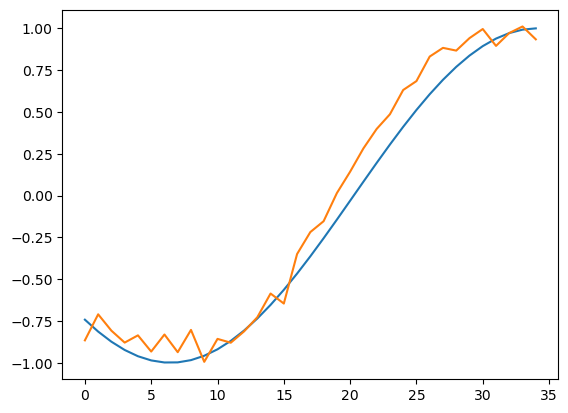

<RET> 


Final:   Epoch 99 training loss 0.012379000894725323 (lr=2e-05)


In [188]:
num_of_epochs = 100
# EDITED loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[100], gamma=0.1)
model.train()

for n in range(num_of_epochs):
    running_loss = 0.0
    X_in = X_tr.float()
    Y_in = Y_tr[:,:-1].float()
    Y_out = Y_tr[:,1:].float()

    # Add dimension for feature
    X_in = torch.unsqueeze(X_in,2)
    X_in = torch.permute(X_in,(1,0,2))
    Y_in = torch.unsqueeze(Y_in,2)
    Y_in = torch.permute(Y_in,(1,0,2))
    #Y_out = torch.unsqueeze(Y_out,2)
    
    # EDITED (no mask needed) tgt_padding_mask_in = tgt_padding_mask[:,:-1]
    
    # Get mask to mask out the next words
    sequence_length = Y_in.size(0)
    tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequence_length)
    # EDITED Y_pred = model(X_in,Y_in, tgt_mask = tgt_mask, src_key_padding_mask = src_padding_mask,
    #               tgt_key_padding_mask = tgt_padding_mask_in)
    Y_pred = model(X_in,Y_in, tgt_mask = tgt_mask)

    if np.random.random() < 0.01:
        plt.plot(range(Y_in.size(0)),Y_in[:,0,0].detach().numpy(), range(Y_pred.size(0)),Y_pred[:,0,0].detach().numpy())
        plt.show()
        input('<RET>')
    # seq len x num samples => num samples x seq len
    Y_out = Y_out.permute(1,0)
    # seq len x num samples x token one hot => num samples x token one hot x seq len    
    #Y_pred = Y_pred.permute(1, 2, 0)
    Y_pred = torch.squeeze(Y_pred)
    loss = loss_fn(Y_pred,Y_out)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    scheduler.step()
    if n % 20 == 0:
        print(f'   Epoch {n} training loss {running_loss} (lr={optimizer.param_groups[0]["lr"]})')
print(f'Final:   Epoch {n} training loss {running_loss} (lr={optimizer.param_groups[0]["lr"]})')

torch.Size([41, 101])
Average MSE over 41 trajectories is 1.4183592796325684 degrees
Average MAE over 41 trajectories is 11.585448265075684 degrees
Training trajectory and prediction number 0


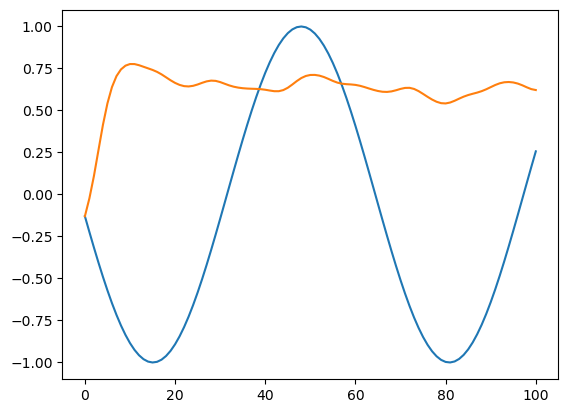

In [127]:
model.eval()
print_ind = np.random.randint(0,10)
print_ind = 0

ind = -1
theta_mse = []
theta_mae = []

print(Y_tr.shape)
for ind in range(10):
    X_in = X_tr[ind,:].float()
    Y_in = Y_tr[ind,0].float() # Only the first value
    #Y_out = Y_tr[ind,1:].float()
    Y_out = Y_tr[ind,:].float()

    # Add dimension for feature
    X_in = torch.unsqueeze(X_in,1)
    #X_in = torch.permute(X_in,(1,0))
    Y_in = torch.unsqueeze(Y_in,0)
    Y_in = torch.unsqueeze(Y_in,1)
    Y_out = torch.unsqueeze(Y_out,1)
    
    y_pred = torch.empty(Y_out.shape)
    y_pred[0] = Y_in # or SOS token

    for te_ind in range(1,Y_out.shape[0]):
        target_in = y_pred[:te_ind]
        # Get mask to mask out the next words
        sequence_length = target_in.size(0)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequence_length)
        
        #pred = model_tr(src, target_in,gen_tgt_mask = False).detach()
        pred = model(X_in, target_in, tgt_mask = tgt_mask).detach()
        pred = torch.squeeze(pred,1)

    #y_pred = y_pred.detach()
    #y_pred[0,:] = src

        y_pred[1:te_ind+1] = pred

    if ind == print_ind:
        y_plot = Y_out
        y_pred_plot = y_pred

    theta_mse.append(torch.sqrt(torch.sum(torch.pow(Y_out[:,0]-y_pred[:,0],2)))/Y_out.shape[0])
    theta_mae.append(torch.sum(abs(Y_out[:,0]-y_pred[:,0]))/Y_out.shape[0])
    
avg_theta_mse = sum(theta_mse)/N_tr
avg_theta_mae = sum(theta_mae)/N_tr
print(f'Average MSE over {N_tr} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_tr} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Training trajectory and prediction number {print_ind}')
plt.plot(range(y_plot.size(0)),y_plot,range(y_pred_plot.size(0)),y_pred_plot)
plt.show()